In [1]:
# # # /trading_bot/main_trading_notebook.ipynb

# # # === IMPORTS AND SETUP ===
# # # Standard library imports
# # import asyncio
# # import json
# # from datetime import datetime
# # from typing import TypedDict, Dict, List

# # # Third-party imports
# # from langgraph.graph import StateGraph, END
# # from IPython.display import Image, display

# # # --- Local Module Imports ---
# # # Import functions from our new helper files
# # from config import *
# # from utils import *
# # from market_data import *
# # from agent import *
# # from reporting import *
# # from diagnostics import *

# # # This ensures ib_async can run in a Jupyter environment
# # import nest_asyncio
# # nest_asyncio.apply()


# # # === AGENT STATE DEFINITION ===
# # class PortfolioState(TypedDict):
# #     """Defines the state that flows through the agent graph."""
# #     timestamp: str
# #     cycle_number: int
# #     portfolio_stocks: List[str]
# #     stock_data: Dict[str, Dict]
# #     stock_prices: Dict[str, float]
# #     stock_smas: Dict[str, float]
# #     ai_trend_analysis: Dict[str, Dict]
# #     positions: Dict[str, int]
# #     stock_pnls: Dict[str, float]
# #     purchase_prices: Dict[str, float]
# #     total_portfolio_value: float
# #     total_unrealized_pnl: float
# #     total_trades: int
# #     total_fees_paid: float
# #     cash_available: float
# #     ai_recommendations: Dict[str, Dict]
# #     executed_trades: List[Dict]
# #     portfolio_allocation: Dict[str, float]
# #     session_start_time: str
# #     session_id: str
# #     cycle_history: List[Dict]
# #     # Validation fields
# #     validation_attempts: int
# #     validation_history: List[Dict]
# #     final_decision_logic: str


# # # === AGENT GRAPH NODES ===
# # # Each node is a step in the agent's thinking process.

# # async def analyze_portfolio_node(state: PortfolioState) -> PortfolioState:
# #     """Node to fetch market data and update the state."""
# #     print(f"\n--- Cycle {state['cycle_number']}: Analyzing Market ---")
# #     stock_data = await get_stock_data_batch(state['portfolio_stocks'])
    
# #     state['timestamp'] = datetime.now().isoformat()
# #     state['stock_data'] = stock_data
# #     state['stock_prices'] = {s: d.get('current_price', 0) for s, d in stock_data.items()}
# #     state['stock_smas'] = {s: d.get('sma_20', 0) for s, d in stock_data.items()}
    
# #     valid_count = len([s for s, d in stock_data.items() if d.get('valid')])
# #     print(f"✅ Analysis complete. Fetched valid data for {valid_count}/{len(state['portfolio_stocks'])} stocks.")
# #     return state

# # async def ai_trend_analysis_node(state: PortfolioState) -> PortfolioState:
# #     """Node for the AI to analyze trends for each stock."""
# #     print("🤖 Running AI trend analysis...")
# #     ai_trend_analysis = {}
# #     for symbol in state['portfolio_stocks']:
# #         analysis = await get_ai_trend_analysis(state['stock_data'], symbol)
# #         ai_trend_analysis[symbol] = analysis
# #         await asyncio.sleep(0.2) # Small delay
# #     state['ai_trend_analysis'] = ai_trend_analysis
# #     print("✅ AI trend analysis complete.")
# #     return state

# # async def check_positions_node(state: PortfolioState) -> PortfolioState:
# #     """Node to check current portfolio positions and value."""
# #     print("📊 Checking portfolio positions and value...")
# #     positions, pnls = await get_all_positions()
# #     portfolio_value, cash = await get_portfolio_summary()
    
# #     state['positions'] = positions
# #     state['stock_pnls'] = pnls
# #     state['total_portfolio_value'] = portfolio_value
# #     state['total_unrealized_pnl'] = sum(pnls.values())
# #     state['cash_available'] = cash
    
# #     # Calculate allocation
# #     allocations = {}
# #     for symbol in state['portfolio_stocks']:
# #         if portfolio_value > 0:
# #             stock_value = positions.get(symbol, 0) * state['stock_prices'].get(symbol, 0)
# #             allocations[symbol] = (stock_value / portfolio_value) * 100
# #         else:
# #             allocations[symbol] = 0.0
# #     state['portfolio_allocation'] = allocations
    
# #     print(f"✅ Positions checked. Value: ${portfolio_value:,.2f}, P&L: ${state['total_unrealized_pnl']:+.2f}")
# #     return state

# # async def ai_decision_node(state: PortfolioState) -> PortfolioState:
# #     """Node for the AI to make trading decisions."""
# #     print("🧠 Generating AI trading recommendations...")
    
# #     # Check for emergency stop-loss first
# #     if check_emergency_stop_loss(state):
# #         print("🚨 EMERGENCY STOP-LOSS: Recommending SELL on all positions!")
# #         recs = {s: {'action': 'SELL', 'priority': 'HIGH', 'reasoning': 'Portfolio stop-loss'} for s, p in state['positions'].items() if p > 0}
# #     else:
# #         recs = await get_ai_portfolio_recommendations(state)

# #     # Override with individual stop-loss/take-profit triggers
# #     stop_loss_actions = check_stop_loss_conditions(state)
# #     for symbol, action in stop_loss_actions.items():
# #         recs[symbol] = {'action': action, 'priority': 'HIGH', 'reasoning': f'Triggered {action} based on price change'}

# #     state['ai_recommendations'] = recs
# #     # --- ADD THIS BLOCK TO LOG THE PARSED RECOMMENDATIONS ---
# #     print("--- PARSED AI RECOMMENDATIONS ---")
# #     if recs:
# #         for symbol, recommendation in recs.items():
# #             action = recommendation.get('action', 'N/A')
# #             priority = recommendation.get('priority', 'N/A')
# #             reason = recommendation.get('reasoning', 'N/A')
# #             score = recommendation.get('technical_score', 'N/A')
# #             print(f"  - {symbol}: {action} (Priority: {priority}, Score: {score}) - Reason: {reason}")
# #     else:
# #         print("  - No valid recommendations were parsed from the AI response.")
# #     print("---------------------------------")
# #     # --- END OF NEW BLOCK ---

# #     print("✅ AI recommendations generated.")
# #     return state
    
# # async def validate_decisions_node(state: PortfolioState) -> PortfolioState:
# #     """Node that runs the validation logic."""
# #     print("🕵️  Validating AI Decisions...")
    
# #     # Prevent infinite loops by limiting validation attempts
# #     if state.get('validation_attempts', 0) >= 2:
# #         print("⚠️ Max validation attempts reached. Proceeding with last decision.")
# #         state['final_decision_logic'] = "Forced proceed after max validation retries."
# #         # Ensure history reflects this forced decision
# #         state['validation_history'].append({'decision': 'proceed', 'reason': 'Max retries.'})
# #         return state

# #     validation_result = validate_ai_decisions(state)
    
# #     # Log the validation attempt
# #     history = state.get('validation_history', [])
# #     history.append({
# #         'timestamp': datetime.now().isoformat(),
# #         'attempt': state.get('validation_attempts', 0) + 1,
# #         **validation_result
# #     })
# #     state['validation_history'] = history
# #     state['validation_attempts'] = state.get('validation_attempts', 0) + 1
    
# #     if validation_result['decision'] == 'proceed':
# #         print(f"✅ Validation Passed: {validation_result['reason']}")
# #         state['final_decision_logic'] = validation_result['reason']
# #     else:
# #         print(f"❌ Validation Failed: {validation_result['reason']}. Rerunning...")
# #         state['final_decision_logic'] = f"Rerun after attempt {state['validation_attempts']}"

# #     return state

# # async def execute_trades_node(state: PortfolioState) -> PortfolioState:
# #     """Node to execute trades based on final recommendations."""
# #     print("⚡ Executing trades...")
# #     recommendations = state.get('ai_recommendations', {})
# #     executed_trades = []
    
# #     # Sort by priority (HIGH > MEDIUM > LOW)
# #     priority_order = {'HIGH': 3, 'MEDIUM': 2, 'LOW': 1}
# #     sorted_recs = sorted(recommendations.items(), key=lambda x: priority_order.get(x[1].get('priority'), 0), reverse=True)
    
# #     for symbol, rec in sorted_recs:
# #         action = rec.get('action')
# #         # Here you would add the full execution logic from your original script
# #         # For brevity, we'll just log the intent
# #         if action in ['BUY', 'SELL']:
# #             # result = await place_smart_order(symbol, action, TRADE_SIZE)
# #             # This is where the full trade execution logic would go, updating
# #             # cash, positions, fees, purchase_prices etc.
# #             # The logic from your `enhanced_execute_trades_node` should be adapted here.
# #             print(f"   - Executing {action} for {symbol}")
# #             executed_trades.append({'symbol': symbol, 'action': action, 'quantity': TRADE_SIZE, 'price': state['stock_prices'].get(symbol)})

# #     state['executed_trades'] = executed_trades
# #     state['total_trades'] += len(executed_trades)
# #     print(f"✅ Execution complete. {len(executed_trades)} trades attempted.")
# #     return state

# # async def reporting_node(state: PortfolioState) -> PortfolioState:
# #     """Node to generate and save all reports."""
# #     print("📝 Generating reports...")
    
# #     # Add current cycle data to history for performance tracking
# #     cycle_data = {k: v for k, v in state.items() if k != 'cycle_history'}
# #     state['cycle_history'].append(cycle_data)
    
# #     generate_html_report(state)
# #     generate_json_report(state)
# #     generate_csv_report(state)
    
# #     print("✅ Reports generated and saved.")
# #     return state


# # # === GRAPH CONSTRUCTION ===
# # def create_trading_graph():
# #     """Builds the LangGraph agent."""
# #     workflow = StateGraph(PortfolioState)

# #     # Add nodes
# #     workflow.add_node("analyze", analyze_portfolio_node)
# #     workflow.add_node("ai_trend", ai_trend_analysis_node)
# #     workflow.add_node("check_positions", check_positions_node)
# #     workflow.add_node("ai_decision", ai_decision_node)
# #     workflow.add_node("validator", validate_decisions_node)
# #     workflow.add_node("execute", execute_trades_node)
# #     workflow.add_node("reporting", reporting_node)

# #     # Define edges
# #     workflow.set_entry_point("analyze")
# #     workflow.add_edge("analyze", "ai_trend")
# #     workflow.add_edge("ai_trend", "check_positions")
# #     workflow.add_edge("check_positions", "ai_decision")
# #     workflow.add_edge("ai_decision", "validator")
    
# #     # Conditional edge for validation loop
# #     workflow.add_conditional_edges(
# #         "validator",
# #         should_rerun_or_proceed,
# #         {
# #             "rerun_decision": "ai_decision",  # Loop back to reconsider
# #             "proceed_to_execute": "execute"  # Continue to execution
# #         }
# #     )
    
# #     workflow.add_edge("execute", "reporting")
# #     workflow.add_edge("reporting", END)

# #     return workflow.compile()

# # # Create the graph instance
# # trading_graph = create_trading_graph()

# # # Visualize the graph
# # try:
# #     img_data = trading_graph.get_graph().draw_mermaid_png()
# #     display(Image(img_data))
# # except Exception as e:
# #     print(f"Could not draw graph, ensure you have `mermaid-cli` installed if needed: {e}")


# # # === MAIN EXECUTION LOOP ===
# # async def run_trading_session(cycles=5, interval_minutes=5):
# #     """Main function to run the trading bot for a session."""
# #     print("🚀 INITIALIZING AI TRADING SESSION 🚀")
    
# #     # Initial state
# #     initial_state = {
# #         'timestamp': "", 'cycle_number': 0, 'portfolio_stocks': PORTFOLIO_STOCKS,
# #         'stock_data': {}, 'stock_prices': {}, 'stock_smas': {}, 'ai_trend_analysis': {},
# #         'positions': {s: 0 for s in PORTFOLIO_STOCKS}, 'stock_pnls': {s: 0.0 for s in PORTFOLIO_STOCKS},
# #         'purchase_prices': {s: 0.0 for s in PORTFOLIO_STOCKS}, 'total_portfolio_value': 0.0,
# #         'total_unrealized_pnl': 0.0, 'total_trades': 0, 'total_fees_paid': 0.0,
# #         'cash_available': 0.0, 'ai_recommendations': {}, 'executed_trades': [],
# #         'portfolio_allocation': {}, 'session_start_time': datetime.now().isoformat(),
# #         'session_id': generate_session_id(), 'cycle_history': [],
# #         'validation_attempts': 0, 'validation_history': [], 'final_decision_logic': 'N/A'
# #     }

# #     current_state = initial_state
# #     try:
# #         for cycle in range(1, cycles + 1):
# #             current_state['cycle_number'] = cycle
# #             current_state['validation_attempts'] = 0 # Reset for new cycle
# #             current_state['validation_history'] = []

# #             if not is_market_open():
# #                 print(f"⏰ Market is closed. Waiting...")
# #                 await asyncio.sleep(60 * 5) # Check every 5 minutes
# #                 continue
            
# #             # Invoke the graph for one cycle
# #             result_state = await trading_graph.ainvoke(current_state)
            
# #             # Persist the state for the next cycle
# #             current_state.update(result_state)
            
# #             print(f"--- Cycle {cycle} complete. Waiting {interval_minutes} minutes. ---")
# #             if cycle < cycles:
# #                 await asyncio.sleep(interval_minutes * 60)
    
# #     except KeyboardInterrupt:
# #         print("\n🛑 Trading session stopped by user.")
# #     except Exception as e:
# #         print(f"\n❌ An unexpected error occurred: {e}")
# #         import traceback
# #         traceback.print_exc()
# #     finally:
# #         print("\n--- SESSION FINISHED ---")
# #         # Optional: Generate a final performance report here
# #         # generate_performance_summary_report(current_state)
# #         print("✅ Final reports generated.")






# # /trading_bot/main_trading_notebook.ipynb

# # === IMPORTS AND SETUP ===
# import asyncio
# import json
# from datetime import datetime
# from typing import TypedDict, Dict, List

# from langgraph.graph import StateGraph, END
# from IPython.display import Image, display

# from config import *
# from utils import *
# from market_data import *
# from agent import *
# from reporting import *
# from diagnostics import *

# import nest_asyncio
# nest_asyncio.apply()


# # === AGENT STATE DEFINITION ===
# class PortfolioState(TypedDict):
#     """Defines the state that flows through the agent graph."""
#     timestamp: str
#     cycle_number: int
#     portfolio_stocks: List[str]
#     stock_data: Dict[str, Dict]
#     stock_prices: Dict[str, float]
#     stock_smas: Dict[str, float]
#     ai_trend_analysis: Dict[str, Dict]
#     positions: Dict[str, int]
#     stock_pnls: Dict[str, float]
#     purchase_prices: Dict[str, float]
#     total_portfolio_value: float
#     total_unrealized_pnl: float
#     total_trades: int
#     total_fees_paid: float
#     cash_available: float
#     ai_recommendations: Dict[str, Dict]
#     executed_trades: List[Dict]
#     portfolio_allocation: Dict[str, float]
#     session_start_time: str
#     session_id: str
#     cycle_history: List[Dict]
#     validation_attempts: int
#     validation_history: List[Dict]
#     final_decision_logic: str
#     # --- NEW FIELD FOR FEEDBACK ---
#     validation_feedback: str


# # === AGENT GRAPH NODES ===
# # (analyze_portfolio_node, ai_trend_analysis_node, check_positions_node remain the same)
# async def analyze_portfolio_node(state: PortfolioState) -> PortfolioState:
#     """Node to fetch market data and update the state."""
#     print(f"\n--- Cycle {state['cycle_number']}: Analyzing Market ---")
#     stock_data = await get_stock_data_batch(state['portfolio_stocks'])
    
#     state['timestamp'] = datetime.now().isoformat()
#     state['stock_data'] = stock_data
#     state['stock_prices'] = {s: d.get('current_price', 0) for s, d in stock_data.items()}
#     state['stock_smas'] = {s: d.get('sma_20', 0) for s, d in stock_data.items()}
    
#     valid_count = len([s for s, d in stock_data.items() if d.get('valid')])
#     print(f"✅ Analysis complete. Fetched valid data for {valid_count}/{len(state['portfolio_stocks'])} stocks.")
#     return state

# async def ai_trend_analysis_node(state: PortfolioState) -> PortfolioState:
#     """Node for the AI to analyze trends for each stock."""
#     print("🤖 Running AI trend analysis...")
#     ai_trend_analysis = {}
#     for symbol in state['portfolio_stocks']:
#         analysis = await get_ai_trend_analysis(state['stock_data'], symbol)
#         ai_trend_analysis[symbol] = analysis
#         await asyncio.sleep(0.2)
#     state['ai_trend_analysis'] = ai_trend_analysis
#     print("✅ AI trend analysis complete.")
#     return state

# async def check_positions_node(state: PortfolioState) -> PortfolioState:
#     """Node to check current portfolio positions and value."""
#     print("📊 Checking portfolio positions and value...")
#     positions, pnls = await get_all_positions()
#     portfolio_value, cash = await get_portfolio_summary()
    
#     state['positions'] = positions
#     state['stock_pnls'] = pnls
#     state['total_portfolio_value'] = portfolio_value
#     state['total_unrealized_pnl'] = sum(pnls.values())
#     state['cash_available'] = cash
    
#     allocations = {}
#     for symbol in state['portfolio_stocks']:
#         if portfolio_value > 0:
#             stock_value = positions.get(symbol, 0) * state['stock_prices'].get(symbol, 0)
#             allocations[symbol] = (stock_value / portfolio_value) * 100
#         else:
#             allocations[symbol] = 0.0
#     state['portfolio_allocation'] = allocations
    
#     print(f"✅ Positions checked. Value: ${portfolio_value:,.2f}, P&L: ${state['total_unrealized_pnl']:+.2f}")
#     return state

# async def ai_decision_node(state: PortfolioState) -> PortfolioState:
#     """Node for the AI to make trading decisions."""
#     # The first time this runs, state['validation_feedback'] will be empty.
#     # If the graph loops back, it will contain the reason for the failure.
#     if state.get("validation_feedback"):
#         print("🧠 Re-generating AI recommendations with validation feedback...")
#     else:
#         print("🧠 Generating initial AI trading recommendations...")
    
#     if check_emergency_stop_loss(state):
#         print("🚨 EMERGENCY STOP-LOSS: Recommending SELL on all positions!")
#         recs = {s: {'action': 'SELL', 'priority': 'HIGH', 'reasoning': 'Portfolio stop-loss'} for s, p in state['positions'].items() if p > 0}
#     else:
#         recs = await get_ai_portfolio_recommendations(state)

#     stop_loss_actions = check_stop_loss_conditions(state)
#     for symbol, action in stop_loss_actions.items():
#         recs[symbol] = {'action': action, 'priority': 'HIGH', 'reasoning': f'Triggered {action} based on price change'}

#     state['ai_recommendations'] = recs
#     print("✅ AI recommendations generated.")
#     return state

# async def validate_decisions_node(state: PortfolioState) -> PortfolioState:
#     """Node that runs the validation logic and stores feedback."""
#     print("🕵️  Validating AI Decisions...")
    
#     if state.get('validation_attempts', 0) >= 2:
#         print("⚠️ Max validation attempts reached. Proceeding with last decision.")
#         state['final_decision_logic'] = "Forced proceed after max validation retries."
#         state['validation_history'].append({'decision': 'proceed', 'reason': 'Max retries.'})
#         state['validation_feedback'] = "" # Clear feedback
#         return state

#     validation_result = validate_ai_decisions(state)
    
#     history = state.get('validation_history', [])
#     history.append({
#         'timestamp': datetime.now().isoformat(),
#         'attempt': state.get('validation_attempts', 0) + 1,
#         **validation_result
#     })
#     state['validation_history'] = history
#     state['validation_attempts'] = state.get('validation_attempts', 0) + 1
    
#     # --- MODIFIED SECTION ---
#     if validation_result['decision'] == 'proceed':
#         print(f"✅ Validation Passed: {validation_result['reason']}")
#         state['final_decision_logic'] = validation_result['reason']
#         state['validation_feedback'] = "" # Clear feedback on success
#     else:
#         print(f"❌ Validation Failed: {validation_result['reason']}. Rerunning...")
#         state['final_decision_logic'] = f"Rerun after attempt {state['validation_attempts']}"
#         state['validation_feedback'] = validation_result['reason'] # Pass feedback for rerun

#     return state

# # (execute_trades_node and reporting_node remain the same)
# async def execute_trades_node(state: PortfolioState) -> PortfolioState:
#     """Node to execute trades based on final recommendations."""
#     print("⚡ Executing trades...")
#     # NOTE: You should have your full trade execution logic here.
#     # This is a placeholder to show the flow.
#     recommendations = state.get('ai_recommendations', {})
#     executed_trades = []
    
#     priority_order = {'HIGH': 3, 'MEDIUM': 2, 'LOW': 1}
#     sorted_recs = sorted(recommendations.items(), key=lambda x: priority_order.get(x[1].get('priority', 'LOW'), 0), reverse=True)
    
#     for symbol, rec in sorted_recs:
#         action = rec.get('action')
#         if action in ['BUY', 'SELL']:
#             print(f"   - Executing {action} for {symbol}")
#             executed_trades.append({'symbol': symbol, 'action': action, 'quantity': TRADE_SIZE, 'price': state['stock_prices'].get(symbol)})

#     state['executed_trades'] = executed_trades
#     state['total_trades'] += len(executed_trades)
#     print(f"✅ Execution complete. {len(executed_trades)} trades attempted.")
#     return state

# async def reporting_node(state: PortfolioState) -> PortfolioState:
#     """Node to generate and save all reports."""
#     print("📝 Generating reports...")
    
#     cycle_data = {k: v for k, v in state.items() if k != 'cycle_history'}
#     state['cycle_history'].append(cycle_data)
    
#     generate_html_report(state)
#     generate_json_report(state)
#     generate_csv_report(state)
    
#     print("✅ Reports generated and saved.")
#     return state

# # === GRAPH CONSTRUCTION ===
# # (This section remains unchanged)
# def create_trading_graph():
#     workflow = StateGraph(PortfolioState)
#     workflow.add_node("analyze", analyze_portfolio_node)
#     workflow.add_node("ai_trend", ai_trend_analysis_node)
#     workflow.add_node("check_positions", check_positions_node)
#     workflow.add_node("ai_decision", ai_decision_node)
#     workflow.add_node("validator", validate_decisions_node)
#     workflow.add_node("execute", execute_trades_node)
#     workflow.add_node("reporting", reporting_node)
#     workflow.set_entry_point("analyze")
#     workflow.add_edge("analyze", "ai_trend")
#     workflow.add_edge("ai_trend", "check_positions")
#     workflow.add_edge("check_positions", "ai_decision")
#     workflow.add_edge("ai_decision", "validator")
#     workflow.add_conditional_edges(
#         "validator",
#         should_rerun_or_proceed,
#         {"rerun_decision": "ai_decision", "proceed_to_execute": "execute"}
#     )
#     workflow.add_edge("execute", "reporting")
#     workflow.add_edge("reporting", END)
#     return workflow.compile()

# trading_graph = create_trading_graph()
# try:
#     display(Image(trading_graph.get_graph().draw_mermaid_png()))
# except Exception as e:
#     print(f"Could not draw graph: {e}")


# # === MAIN EXECUTION LOOP ===
# async def run_trading_session(cycles=5, interval_minutes=5):
#     """Main function to run the trading bot for a session."""
#     print("🚀 INITIALIZING AI TRADING SESSION 🚀")
    
#     # --- MODIFIED INITIAL STATE ---
#     initial_state = {
#         'timestamp': "", 'cycle_number': 0, 'portfolio_stocks': PORTFOLIO_STOCKS,
#         'stock_data': {}, 'stock_prices': {}, 'stock_smas': {}, 'ai_trend_analysis': {},
#         'positions': {s: 0 for s in PORTFOLIO_STOCKS}, 'stock_pnls': {s: 0.0 for s in PORTFOLIO_STOCKS},
#         'purchase_prices': {s: 0.0 for s in PORTFOLIO_STOCKS}, 'total_portfolio_value': 0.0,
#         'total_unrealized_pnl': 0.0, 'total_trades': 0, 'total_fees_paid': 0.0,
#         'cash_available': 0.0, 'ai_recommendations': {}, 'executed_trades': [],
#         'portfolio_allocation': {}, 'session_start_time': datetime.now().isoformat(),
#         'session_id': generate_session_id(), 'cycle_history': [],
#         'validation_attempts': 0, 'validation_history': [], 'final_decision_logic': 'N/A',
#         'validation_feedback': "" # Initialize feedback as empty
#     }

#     current_state = initial_state
#     try:
#         for cycle in range(1, cycles + 1):
#             # --- MODIFIED CYCLE RESET ---
#             current_state['cycle_number'] = cycle
#             current_state['validation_attempts'] = 0
#             current_state['validation_history'] = []
#             current_state['validation_feedback'] = "" # Reset feedback for each new cycle

#             if not is_market_open():
#                 print(f"⏰ Market is closed. Waiting...")
#                 await asyncio.sleep(60 * 5)
#                 continue
            
#             result_state = await trading_graph.ainvoke(current_state)
#             current_state.update(result_state)
            
#             print(f"--- Cycle {cycle} complete. Waiting {interval_minutes} minutes. ---")
#             if cycle < cycles:
#                 await asyncio.sleep(interval_minutes * 60)
    
#     except KeyboardInterrupt:
#         print("\n🛑 Trading session stopped by user.")
#     except Exception as e:
#         print(f"\n❌ An unexpected error occurred: {e}")
#         import traceback
#         traceback.print_exc()
#     finally:
#         print("\n--- SESSION FINISHED ---")
#         print("✅ Final reports generated.")



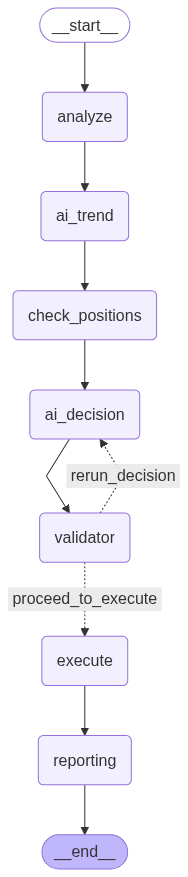

In [2]:
# /trading_bot/main_trading_notebook.ipynb

# === IMPORTS AND SETUP ===
import asyncio
import json
from datetime import datetime
from typing import TypedDict, Dict, List

from langgraph.graph import StateGraph, END
from IPython.display import Image, display

from config import *
from utils import *
from market_data import *
from agent import *
from reporting import *
from diagnostics import *

import nest_asyncio
nest_asyncio.apply()


# === AGENT STATE DEFINITION ===
class PortfolioState(TypedDict):
    """Defines the state that flows through the agent graph."""
    timestamp: str
    cycle_number: int
    portfolio_stocks: List[str]
    stock_data: Dict[str, Dict]
    stock_prices: Dict[str, float]
    stock_smas: Dict[str, float]
    ai_trend_analysis: Dict[str, Dict]
    positions: Dict[str, int]
    stock_pnls: Dict[str, float]
    purchase_prices: Dict[str, float]
    total_portfolio_value: float
    total_unrealized_pnl: float
    total_trades: int
    total_fees_paid: float
    cash_available: float
    ai_recommendations: Dict[str, Dict]
    executed_trades: List[Dict]
    portfolio_allocation: Dict[str, float]
    session_start_time: str
    session_id: str
    cycle_history: List[Dict]
    validation_attempts: int
    validation_history: List[Dict]
    final_decision_logic: str
    validation_feedback: str
    # --- NEW FIELD FOR STRATEGY ---
    aggressive_mode: bool


# === AGENT GRAPH NODES ===
async def analyze_portfolio_node(state: PortfolioState) -> PortfolioState:
    """Node to fetch market data and update the state."""
    print(f"\n--- Cycle {state['cycle_number']}: Analyzing Market ---")
    stock_data = await get_stock_data_batch(state['portfolio_stocks'])
    
    state['timestamp'] = datetime.now().isoformat()
    state['stock_data'] = stock_data
    state['stock_prices'] = {s: d.get('current_price', 0) for s, d in stock_data.items()}
    state['stock_smas'] = {s: d.get('sma_20', 0) for s, d in stock_data.items()}
    
    valid_count = len([s for s, d in stock_data.items() if d.get('valid')])
    print(f"✅ Analysis complete. Fetched valid data for {valid_count}/{len(state['portfolio_stocks'])} stocks.")
    return state

async def ai_trend_analysis_node(state: PortfolioState) -> PortfolioState:
    """Node for the AI to analyze trends for each stock."""
    print("🤖 Running AI trend analysis...")
    ai_trend_analysis = {}
    for symbol in state['portfolio_stocks']:
        analysis = await get_ai_trend_analysis(state['stock_data'], symbol)
        ai_trend_analysis[symbol] = analysis
        await asyncio.sleep(0.2)
    state['ai_trend_analysis'] = ai_trend_analysis
    print("✅ AI trend analysis complete.")
    return state

async def check_positions_node(state: PortfolioState) -> PortfolioState:
    """Node to check current portfolio positions and value."""
    print("📊 Checking portfolio positions and value...")
    positions, pnls = await get_all_positions()
    portfolio_value, cash = await get_portfolio_summary()
    
    state['positions'] = positions
    state['stock_pnls'] = pnls
    state['total_portfolio_value'] = portfolio_value
    state['total_unrealized_pnl'] = sum(pnls.values())
    state['cash_available'] = cash
    
    allocations = {}
    for symbol in state['portfolio_stocks']:
        if portfolio_value > 0:
            stock_value = positions.get(symbol, 0) * state['stock_prices'].get(symbol, 0)
            allocations[symbol] = (stock_value / portfolio_value) * 100
        else:
            allocations[symbol] = 0.0
    state['portfolio_allocation'] = allocations
    
    print(f"✅ Positions checked. Value: ${portfolio_value:,.2f}, P&L: ${state['total_unrealized_pnl']:+.2f}")
    return state

async def ai_decision_node(state: PortfolioState) -> PortfolioState:
    """Node for the AI to make trading decisions."""
    strategy_mode = "Aggressive" if state.get('aggressive_mode') else "Balanced"
    
    if state.get("validation_feedback"):
        print(f"🧠 Re-generating AI recommendations ({strategy_mode} Mode) with validation feedback...")
    else:
        print(f"🧠 Generating initial AI recommendations ({strategy_mode} Mode)...")
    
    if check_emergency_stop_loss(state):
        print("🚨 EMERGENCY STOP-LOSS: Recommending SELL on all positions!")
        recs = {s: {'action': 'SELL', 'priority': 'HIGH', 'reasoning': 'Portfolio stop-loss'} for s, p in state['positions'].items() if p > 0}
    else:
        recs = await get_ai_portfolio_recommendations(state)

    stop_loss_actions = check_stop_loss_conditions(state)
    for symbol, action in stop_loss_actions.items():
        recs[symbol] = {'action': action, 'priority': 'HIGH', 'reasoning': f'Triggered {action} based on price change'}

    state['ai_recommendations'] = recs
    print("✅ AI recommendations generated.")
    return state

async def validate_decisions_node(state: PortfolioState) -> PortfolioState:
    """Node that runs the validation logic and stores feedback."""
    print("🕵️  Validating AI Decisions...")
    
    if state.get('validation_attempts', 0) >= 2:
        print("⚠️ Max validation attempts reached. Proceeding with last decision.")
        state['final_decision_logic'] = "Forced proceed after max validation retries."
        state['validation_history'].append({'decision': 'proceed', 'reason': 'Max retries.'})
        state['validation_feedback'] = ""
        return state

    validation_result = validate_ai_decisions(state)
    
    history = state.get('validation_history', [])
    history.append({
        'timestamp': datetime.now().isoformat(),
        'attempt': state.get('validation_attempts', 0) + 1,
        **validation_result
    })
    state['validation_history'] = history
    state['validation_attempts'] = state.get('validation_attempts', 0) + 1
    
    if validation_result['decision'] == 'proceed':
        print(f"✅ Validation Passed: {validation_result['reason']}")
        state['final_decision_logic'] = validation_result['reason']
        state['validation_feedback'] = ""
    else:
        print(f"❌ Validation Failed: {validation_result['reason']}. Rerunning...")
        state['final_decision_logic'] = f"Rerun after attempt {state['validation_attempts']}"
        state['validation_feedback'] = validation_result['reason']

    return state

async def execute_trades_node(state: PortfolioState) -> PortfolioState:
    """Node to execute trades based on final recommendations."""
    print("⚡ Executing trades...")
    recommendations = state.get('ai_recommendations', {})
    executed_trades = []
    
    priority_order = {'HIGH': 3, 'MEDIUM': 2, 'LOW': 1}
    sorted_recs = sorted(recommendations.items(), key=lambda x: priority_order.get(x[1].get('priority', 'LOW'), 0), reverse=True)
    
    for symbol, rec in sorted_recs:
        action = rec.get('action')
        if action in ['BUY', 'SELL']:
            print(f"   - Executing {action} for {symbol}")
            executed_trades.append({'symbol': symbol, 'action': action, 'quantity': TRADE_SIZE, 'price': state['stock_prices'].get(symbol)})

    state['executed_trades'] = executed_trades
    state['total_trades'] += len(executed_trades)
    print(f"✅ Execution complete. {len(executed_trades)} trades attempted.")
    return state

async def reporting_node(state: PortfolioState) -> PortfolioState:
    """Node to generate and save all reports."""
    print("📝 Generating reports...")
    
    cycle_data = {k: v for k, v in state.items() if k != 'cycle_history'}
    state['cycle_history'].append(cycle_data)
    
    generate_html_report(state)
    generate_json_report(state)
    generate_csv_report(state)
    
    print("✅ Reports generated and saved.")
    return state

# === GRAPH CONSTRUCTION ===
def create_trading_graph():
    workflow = StateGraph(PortfolioState)
    workflow.add_node("analyze", analyze_portfolio_node)
    workflow.add_node("ai_trend", ai_trend_analysis_node)
    workflow.add_node("check_positions", check_positions_node)
    workflow.add_node("ai_decision", ai_decision_node)
    workflow.add_node("validator", validate_decisions_node)
    workflow.add_node("execute", execute_trades_node)
    workflow.add_node("reporting", reporting_node)
    workflow.set_entry_point("analyze")
    workflow.add_edge("analyze", "ai_trend")
    workflow.add_edge("ai_trend", "check_positions")
    workflow.add_edge("check_positions", "ai_decision")
    workflow.add_edge("ai_decision", "validator")
    workflow.add_conditional_edges(
        "validator",
        should_rerun_or_proceed,
        {"rerun_decision": "ai_decision", "proceed_to_execute": "execute"}
    )
    workflow.add_edge("execute", "reporting")
    workflow.add_edge("reporting", END)
    return workflow.compile()

trading_graph = create_trading_graph()
try:
    display(Image(trading_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not draw graph: {e}")


# === MAIN EXECUTION LOOP ===
async def run_trading_session(cycles=5, interval_minutes=5, aggressive=False):
    """Main function to run the trading bot for a session."""
    strategy_mode = "AGGRESSIVE" if aggressive else "BALANCED"
    print(f"🚀 INITIALIZING AI TRADING SESSION ({strategy_mode} MODE) 🚀")
    
    initial_state = {
        'timestamp': "", 'cycle_number': 0, 'portfolio_stocks': PORTFOLIO_STOCKS,
        'stock_data': {}, 'stock_prices': {}, 'stock_smas': {}, 'ai_trend_analysis': {},
        'positions': {s: 0 for s in PORTFOLIO_STOCKS}, 'stock_pnls': {s: 0.0 for s in PORTFOLIO_STOCKS},
        'purchase_prices': {s: 0.0 for s in PORTFOLIO_STOCKS}, 'total_portfolio_value': 0.0,
        'total_unrealized_pnl': 0.0, 'total_trades': 0, 'total_fees_paid': 0.0,
        'cash_available': 0.0, 'ai_recommendations': {}, 'executed_trades': [],
        'portfolio_allocation': {}, 'session_start_time': datetime.now().isoformat(),
        'session_id': generate_session_id(), 'cycle_history': [],
        'validation_attempts': 0, 'validation_history': [], 'final_decision_logic': 'N/A',
        'validation_feedback': "",
        'aggressive_mode': aggressive # Set the strategy mode
    }

    current_state = initial_state
    try:
        for cycle in range(1, cycles + 1):
            current_state['cycle_number'] = cycle
            current_state['validation_attempts'] = 0
            current_state['validation_history'] = []
            current_state['validation_feedback'] = ""

            if not is_market_open():
                print(f"⏰ Market is closed. Waiting...")
                await asyncio.sleep(60 * 5)
                continue
            
            result_state = await trading_graph.ainvoke(current_state)
            current_state.update(result_state)
            
            print(f"--- Cycle {cycle} complete. Waiting {interval_minutes} minutes. ---")
            if cycle < cycles:
                await asyncio.sleep(interval_minutes * 60)
    
    except KeyboardInterrupt:
        print("\n🛑 Trading session stopped by user.")
    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()
    finally:
        print("\n--- SESSION FINISHED ---")
        generate_portfolio_status_report(current_state)
        generate_performance_summary_report(current_state)
        await generate_enhanced_performance_and_status_report(current_state)
        print("✅ Final reports generated.")


In [3]:
# To run a short, aggressive trading session
asyncio.run(run_trading_session(cycles=1, interval_minutes=2, aggressive=True))

🚀 INITIALIZING AI TRADING SESSION (AGGRESSIVE MODE) 🚀

--- Cycle 1: Analyzing Market ---
✅ IB Connection successful with Client ID: 5312
✅ Success: Price $224.78, RSI 83.5
📊 Fetching data for GOOGL (2/10)... ✅ Success: Price $202.58, RSI 81.1
📊 Fetching data for META (3/10)... ✅ Success: Price $763.64, RSI 36.9
📊 Fetching data for AMZN (4/10)... ✅ Success: Price $222.65, RSI 64.7
📊 Fetching data for NFLX (5/10)... ✅ Success: Price $1194.31, RSI 69.7
📊 Fetching data for MSFT (6/10)... ✅ Success: Price $520.95, RSI 32.2
📊 Fetching data for NVDA (7/10)... ✅ Success: Price $182.72, RSI 64.4
📊 Fetching data for TSLA (8/10)... ✅ Success: Price $332.66, RSI 77.6
📊 Fetching data for CRM (9/10)... ✅ Success: Price $239.56, RSI 29.1
📊 Fetching data for ADBE (10/10)... ✅ Success: Price $336.96, RSI 41.9
✅ Analysis complete. Fetched valid data for 10/10 stocks.
🤖 Running AI trend analysis...
✅ AI trend analysis complete.
📊 Checking portfolio positions and value...
✅ Positions checked. Value: $999,

Error 10089, reqId 35: Requested market data requires additional subscription for API. See link in 'Market Data Connections' dialog for more details.Delayed market data is available.CRM NYSE/TOP/ALL, contract: Stock(conId=29624264, symbol='CRM', exchange='SMART', primaryExchange='NYSE', currency='USD', localSymbol='CRM', tradingClass='CRM')


⚠️ No valid price for CRM
✅ Portfolio status retrieved successfully
Not enough cycle history for full performance report. Generating status report only.
📈 Complete Portfolio Report saved: portfolio_reports/performance_summary_20250808_153734.html
📄 File uploaded to GCS: gs://portfolio_reports_algo/2025/08/08/performance_summary_20250808_153734.html
✅ Report uploaded to GCS: gs://portfolio_reports_algo/2025/08/08/performance_summary_20250808_153734.html
✅ Final reports generated.


Peer closed connection.


In [4]:
# === EXECUTION & DIAGNOSTICS ===

# To run a full system check before starting:
# await run_full_system_diagnostics()

# To run a short trading session (e.g., 3 cycles every 2 minutes)
# This is the main command to start the bot.
# asyncio.run(run_trading_session(cycles=3, interval_minutes=2))


In [ ]:
# cycles=60, interval_minutes=8

asyncio.run(run_trading_session(cycles=240, interval_minutes=2))


🚀 INITIALIZING AI TRADING SESSION (BALANCED MODE) 🚀

--- Cycle 1: Analyzing Market ---
✅ Success: Price $224.76, RSI 83.5. 
📊 Fetching data for GOOGL (2/10)... ✅ Success: Price $201.99, RSI 80.0
📊 Fetching data for META (3/10)... ✅ Success: Price $764.17, RSI 37.7
📊 Fetching data for AMZN (4/10)... ✅ Success: Price $222.64, RSI 64.6
📊 Fetching data for NFLX (5/10)... ✅ Success: Price $1195.00, RSI 70.4
📊 Fetching data for MSFT (6/10)... ✅ Success: Price $520.52, RSI 31.3
📊 Fetching data for NVDA (7/10)... ✅ Success: Price $182.63, RSI 64.2
📊 Fetching data for TSLA (8/10)... ✅ Success: Price $333.10, RSI 79.0
📊 Fetching data for CRM (9/10)... ✅ Success: Price $239.05, RSI 28.3
📊 Fetching data for ADBE (10/10)... ✅ Success: Price $336.99, RSI 42.0
✅ Analysis complete. Fetched valid data for 10/10 stocks.
🤖 Running AI trend analysis...
✅ AI trend analysis complete.
📊 Checking portfolio positions and value...
✅ Positions checked. Value: $999,448.02, P&L: $+0.00
🧠 Generating initial AI reco